<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/DL_quest/main_quest_04/mq4_holdup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Main Quest 04. 폐렴아 기다려라!


### 학습 내용

* 의료 영상 데이터의 특징과 중요성에 대해 설명하여, 왜 이러한 기술이 의료 분야에서 중요한지 이해합니다.
* X-RAY 이미지의 구조와 폐렴 진단에 어떻게 활용되는지에 대해 살펴봅니다.
* CNN 모델 설계, 데이터 불균형 처리 방법, 모델 훈련, 그리고 마지막으로 모델의 성능을 확인하여 폐렴 진단 결과 평가 및 확인하는 과정을 살펴봅니다.

### 목차

**5. 폐렴아 기다려라**

    5-1. 들어가며
    5-2. 의료영상에 대해
    5-3. X-RAY 이미지
    5-4. 폐렴을 진단해보자 (1)
        1) Set up
        2) 데이터 가져오기
        3) 데이터 시각화

    5-5. 폐렴을 진단해보자 (2)
        4) CNN 모델링
        5) 데이터 imbalance 처리
        6) 모델 훈련
        7) 결과 확인

### 5-4. 폐렴을 진단해보자 (1)

**Dataset**

이번 노드에서 사용할 데이터는 캐글의 Chest X-Ray Images 입니다. 데이터의 구성은 -/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다. (에디터 주) 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있습니다. 중복된 데이터는 필요하지 않습니다. 해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상입니다.

**폐렴이란**

폐렴은 쉽게 말해 폐에 염증이 생기는 것입니다. 일단 폐는 여러분들도 너무 잘 아시는 것과 같이 공기를 들이마셔 호흡 작용을 하는 기관이겠죠? 그럼 염증은 정확히 무엇일까요? 염증은 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 장소라고 할 수 있습니다. 폐렴이라면 폐에서 바이러스나 세균으로부터 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 상황이라고 생각하시면 됩니다. 그럼 폐렴이 걸렸을 때 X-RAY 상에서 어떻게 나오는지 보겠습니다.

**폐렴 구별법**

폐렴의 구별법은 언뜻 예상외로 간단합니다. X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됩니다. 구별 방법은 간단하지만 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어렵습니다. 정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줍니다. `세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴`으로 나타납니다.

**1. Set up**

In [ ]:
# Lib

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

앞으로 필요한 변수들을 생성합니다.

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


**2. 데이터 가져오기**

데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다.

```
├── test
│    ├── NORMAL
│    └── PNEUMONIA
├── train
│    ├── NORMAL
│    └── PNEUMONIA
└── val
     ├── NORMAL
     └── PNEUMONIA
```

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("Train data:", len(train_filenames))
print("Test data:", len(test_filenames))
print("Validation data:", len(val_filenames))

Train data: 5216
Test data: 624
Validation data: 16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.
개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.
train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("Train data:", len(train_filenames))
print("Validation data:", len(val_filenames))

Train data: 4185
Validation data: 1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다. train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다. 정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요?

In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.  
또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다. tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


좋습니다. 현재 이미지에는 라벨 데이터가 따로 없습니다.  
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.  

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

**이미지 데이터는 현실적으로 사이즈가 제각각**일 가능성이 높습니다. 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다. `decode_img 함수`와 `process_path 함수`를 만들겠습니다. process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다.  
`num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리`해 즐 수 있습니다.

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


`폐렴이면 양성(True), 노말이면 음성(False)`! 사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있군요!  
참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다. 위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.  

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("Test image count:", TEST_IMAGE_COUNT)

Test image count: 624


In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.  
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

* shuffle()을 사용하며 고정 크기 버퍼를 유지하고, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
* repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.
* batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
* prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

**3. 데이터 시각화**

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다.  
추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

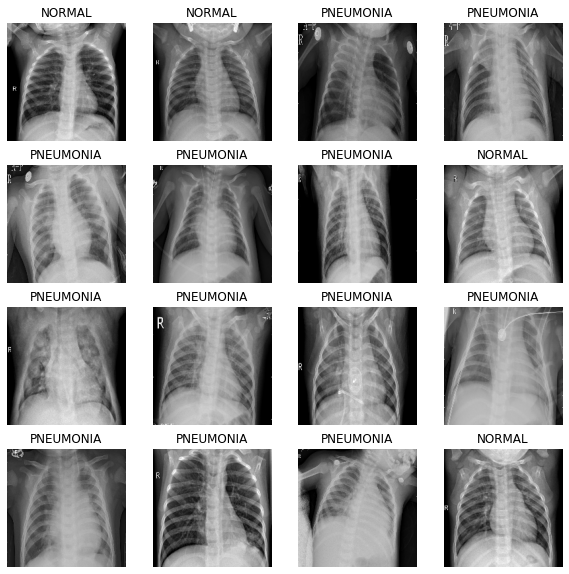

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 5-5. 폐렴을 진단해보자 (2)

**4. CNN 모델링**

이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다. [CNN 요약 참고](http://taewan.kim/post/cnn/).  
먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고, Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

Dense Block은 아래와 같이 만듭니다.

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

`우리가 만들 CNN 모델`은 약간의 수정을 거쳐 만들어진 모델입니다. `전형적인 CNN 모델과는 약간 다른 모델`입니다.어떤 부분이 가장 특이한가요? 만들어진 모델에는 `Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용`되고 있습니다.
일반적으로 `이런 방법은 잘 사용되지 않거나, 금기시`되기도 합니다. 대표적으로 "Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift" [논문의 사례](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)를 들 수 있습니다. 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다. 그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. `예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우`가 실제로 있습니다. 두 방법을 같이 쓰는 것을 옹호하는 경우에 대한 [논문](https://arxiv.org/pdf/1905.05928.pdf) "Rethinking the Usage of Batch Normalization and Dropout in the Training of
Deep Neural Networks"도 있습니다.

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.  

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

**5. 데이터 imbalance 처리**

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? `한 라벨이 너무 많은 경우를 imbalance` 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다. 이런 문제들을 해결하는 방법으로 `Weight balancing`이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 딥러닝에서 클래스 불균형을 다루는 방법 [링크](https://3months.tistory.com/414)를 참고하세요.

아래 코드에서 `weight_for_0`은 '**Normal**' 이미지에 사용할 weight를, `weight_for_1`은 '**Pneumonia**' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


**6. 모델 훈련**

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 `GPU를 선택`합니다. 모델은 위에서 만들었던 모델 함수인 `build_model()을 model에 선언`합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다. 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다.

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 109s 205ms/step - loss: 0.4231 - accuracy: 0.8000 - precision: 0.9487 - recall: 0.7732 - val_loss: 0.6243 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 203ms/step - loss: 0.2164 - accuracy: 0.9145 - precision: 0.9751 - recall: 0.9083 - val_loss: 1.2053 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1955 - accuracy: 0.9291 - precision: 0.9773 - recall: 0.9263 - val_loss: 0.6901 - val_accuracy: 0.7413 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1903 - accuracy: 0.9248 - precision: 0.9775 - recall: 0.9202 - val_loss: 0.1264 - val_accuracy: 0.9462 - val_precision: 0.9796 - val_recall: 0.9462
Epoch 5/10
261/261 [==============================] - 55s 210ms/step - loss: 0.1649 - accur

**7. 결과 확인**

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

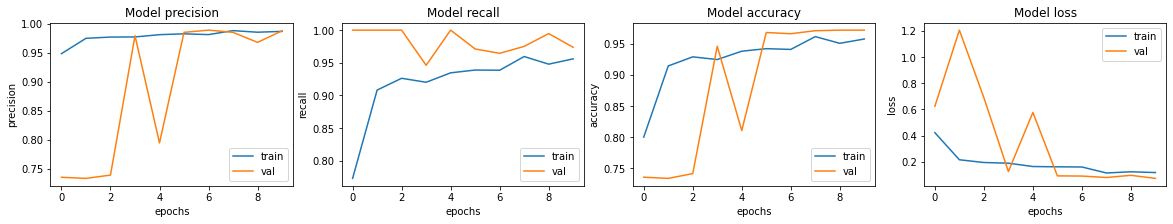

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**테스트 데이터로 모델 평가**를 해보겠습니다. 모델 평가를 위해 `loss`, `accuracy`, `precision`, `recall` 값을 출력해보겠습니다.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 0.6163 - accuracy: 0.8093 - precision: 0.7737 - recall: 0.9821
Loss: 0.616283655166626,
Accuracy: 0.8092948794364929,
Precision: 0.773737370967865,
Recall: 0.9820512533187866


In [ ]:
print("LMS: Epoch 10/10:")
print("\nloss: 0.1350 \naccuracy: 0.9519 \nprecision: 0.9876 \nrecall: 0.9472 \nval_loss: 0.1251 \nval_accuracy: 0.9548 \nval_precision: 0.9972 \nval_recall: 0.9410")
print("\nEvaulation: \nLoss: 0.4681052565574646, \nAccuracy: 0.8541666865348816, \nPrecision: 0.832962155342102, \nRecall: 0.9589743614196777")

print("\nJupiter: Epoch 10/10:")
print("\nloss: 0.1188 \naccuracy: 0.9579 \nprecision: 0.9871 \nrecall: 0.9560 \nval_loss: 0.0744 \nval_accuracy: 0.9721 \nval_precision: 0.9880 \nval_recall: 0.9738")
print("\nEvaulation: \nLoss: 0.616283655166626, \nAccuracy: 0.8092948794364929, \nPrecision: 0.773737370967865, \nRecall: 0.9820512533187866")

LMS: Epoch 10/10:

loss: 0.1350 
accuracy: 0.9519 
precision: 0.9876 
recall: 0.9472 
val_loss: 0.1251 
val_accuracy: 0.9548 
val_precision: 0.9972 
val_recall: 0.9410

Evaulation: 
Loss: 0.4681052565574646, 
Accuracy: 0.8541666865348816, 
Precision: 0.832962155342102, 
Recall: 0.9589743614196777

Jupiter: Epoch 10/10:

loss: 0.1188 
accuracy: 0.9579 
precision: 0.9871 
recall: 0.9560 
val_loss: 0.0744 
val_accuracy: 0.9721 
val_precision: 0.9880 
val_recall: 0.9738

Evaulation: 
Loss: 0.616283655166626, 
Accuracy: 0.8092948794364929, 
Precision: 0.773737370967865, 
Recall: 0.9820512533187866


의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많이 있습니다. 이런 문제를 해결하기 위해 `Data augmentation` 방법을 많이 시도합니다. Data augmentation 은 각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많습니다. 그래서 의료분야에서는 기본적인 Data augmentation 방법들을 많이 사용합니다. 이미지 회전, 가우시안 노이즈 추가 방법 등을 많이 사용합니다. 특히 장기의 크기는 사람마다 거의 바뀌지 않습니다. 이런 특성을 이용한 방법이 노이즈 추가 방법입니다. 전통적인 Data augmentation 방법을 비롯하여 GAN을 이용해서 Data augmentation을 시도하는 연구들도 많이 있으니 참고하면 좋겠습니다.